# ABIDE Subtype analysis @20
Lazy man result overview for anything

In [3]:
# Imports
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
from scipy import io as sio
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [4]:
%matplotlib inline

# Paths

In [33]:
# Variables
subtypes = 5
cov = 'ADOS_SOCOM_SEV'
scale = 20
mtp = 'rmap_part'
name = 'site_279_sample'
pheno_path = '/data1/abide/Pheno/site_balanced_279.csv'

# Fixed values
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
in_path = '/data1/subtypes/serial_preps/'
out_path = '/data1/subtypes/figures_hbm/{}/{}/'.format(mtp, name)
if not os.path.isdir(out_path):
    os.makedirs(out_path)

match_temp = '/data1/cambridge/template/sc{:03d}_overlap/template_cambridge_basc_multiscale_sym_scale{:03d}_matching.mat'
match_path = match_temp.format(scale, 12)

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

In [6]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [7]:
# Get the matching file
match_file = sio.loadmat(match_path)

In [41]:
# Network name lookup table
sc7_names = [
             'Cerebellum',
             'Limbic',
             'Somatomotor',
             'Visual',
             'Default Mode',
             'Frontoparietal',
             'Ventral Attention'
            ]
sc12_names = [
              'Basal Ganglia',
              'Auditory',
              'Limbic',
              'Lateral Default Mode',
              'Visual',
              'Posterior medial Default Mode',
              'Somatomotor',
              'Anterior Default Mode',
              'Higher Visual',
              'Frontoparietal',
              'Ventral Attention',
              'Cerebellum'
              ]

In [9]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [10]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [296]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [12]:
# Define the allrounder function
def get_data(scale, maptype, name, subtypes, cov, pheno):
    # Get the paths
    netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    # Get the files
    netstack = np.load(netstack_path)
    corr_mat = np.load(corrmat_path)
    
    # Make the subtypes
    subtypes = 5
    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))
    
    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])
            
    # Run the GLM
    # Get the subjects that have the covariate
    cov_index = pd.notnull(pheno[cov])
    cov_pheno = pheno[cov_index]
    # Generate the model matrix
    factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = cov_pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    if cov == 'DX_GROUP':
        other_factors[cov] = other_factors[cov].values - 1
    else:
        # Demean the covariate
        other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)

    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    # Get the weights for these subjects
    cov_weight = weight_store[..., cov_index.values]

    # Prepare storage variables
    res_store = list()
    pval_store = np.zeros((scale, subtypes))
    for net_id in range(scale):
        res_list = list()
        # Loop through the subtypes
        for s_id in range(subtypes):
            model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
            results = model.fit()
            # Save the p-values
            pval_store[net_id, s_id] = results.pvalues[cov]
            res_list.append(results)
        res_store.append(res_list)
    # Now look at the mask of p-values passing FDR Correction
    pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
    pcorr_vec = smi.multipletests(pval_vec.flatten(), alpha=0.05, method='fdr_bh')
    pcorr = np.reshape(pcorr_vec[1], pval_store.shape)
    pthresh = np.reshape(pcorr_vec[0], pval_store.shape)

    return (corr_mat, weight_store, sbt_store, res_store, pthresh)

In [13]:
corr_mat, weight_store, sbt_store, res_store, pthresh = get_data(scale, mtp, name, subtypes, cov, pheno)

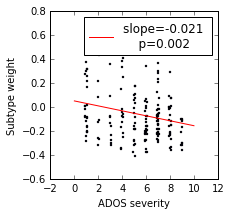

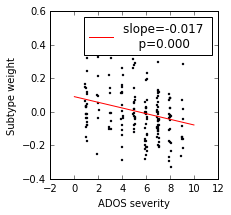

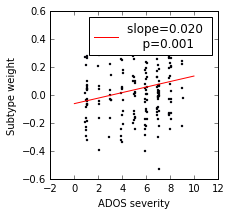

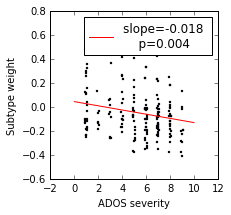

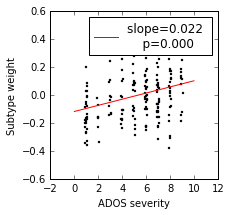

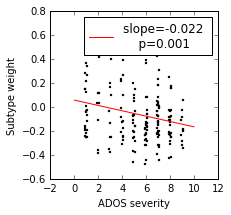

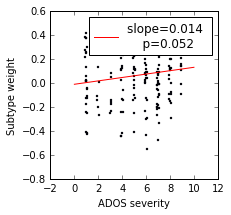

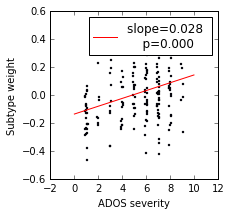

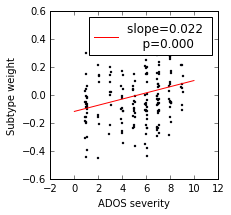

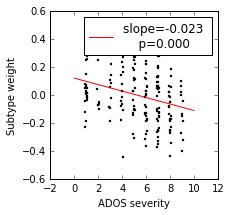

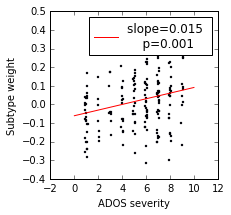

In [319]:
# Get the raw maps
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netstack_raw = np.load(netraw_path)

# Iterate through all above threshold findings
net_hits, sbt_hits = np.where(pthresh)
# Find the unique networks that have hit
nets = np.unique(net_hits)
# Get the pheno stuff
cov_index = pd.notnull(pheno[cov])
cov_val = pheno[cov_index][cov].values
# Setup the text overlay
font = {'family': 'serif',
    'color':  'lime',
    'weight': 'heavy',
    'size': 18,
    }
txt_offset=8

# Loop through the networks
for network in nets:    
    net_match = match_file['ind_ovlp'][network][0]
    # Turn that into the python 0-based net id
    net_match_id = net_match - 1
    # Find the overlap with this network
    net_overlap = match_file['score_ovlp'][network]
    
    # Plot the network
    fig_a = plt.figure(figsize=(6,18))
    gs1 = gridspec.GridSpec(3, 1, hspace=0)
    ax_1a = fig_a.add_subplot(gs1[0,0])
    ax_1b = fig_a.add_subplot(gs1[1,0])
    ax_1c = fig_a.add_subplot(gs1[2,0])
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_1a, display_mode='x')
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_1b, display_mode='y')
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_1c, display_mode='z')
    
    # Save the figure
    fig_name = 'net_{}_fig.png'.format(network)
    fig_a.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)
    plt.close()
    
    # Plot the correlation matrix
    link_mat = scl.hierarchy.linkage(corr_mat[network, ...] , method='ward')
    ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
    tmp = corr_mat[network, ...]
    show_mat = tmp[ind, :][:, ind]
    # Prepare the partition overlay
    part_test = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')[ind]
    part_frame = np.zeros(show_mat.shape)
    text_loc = list()
    for sbt_id in np.arange(subtypes):
        # Get first and last element
        hits = np.where(part_test==sbt_id+1)[0]
        first = hits[0]
        last = hits[-1]
        text_loc.append((len(hits)/2 + first-txt_offset, len(hits)/2 + first+txt_offset))
        # Draw column
        part_frame[first:last, (first, last)] = 1
        # Draw rows 
        part_frame[(first, last), first:last] = 1
    part_frame = np.ma.masked_where(part_frame == 0, part_frame)
    
    fig_b = plt.figure(figsize=(3,3))
    ax_2a = fig_b.add_subplot(111)
    ax_2a.matshow(show_mat, vmin=-0.2, vmax=0.2, cmap=bb.visu.hot_cold())
    ax_2a.matshow(part_frame, cmap=plt.cm.Greys)
    for sbt_id in np.arange(subtypes):
        (x,y) = text_loc[sbt_id]
        ax_2a.text(x,y,'{}'.format(sbt_id), fontdict=font)
    
    fig_name = 'net_{}_corrmat.png'.format(network)
    fig_b.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)
    plt.close()
    
    # Get the subtypes with significant results for 
    # the current network
    sbts = sbt_hits[net_hits==network]
    
    # Now start plotting the subtypes
    for pid, sbt in enumerate(sbts):
        # subtype figure
        fig_c = plt.figure(figsize=(9,3))
        gs3 = gridspec.GridSpec(2, 1, hspace=0)
        ax_3a = fig_c.add_subplot(gs3[0,0])
        ax_3b = fig_c.add_subplot(gs3[1,0])

        res = res_store[network][sbt]
        # Get sbt t-value
        sbt_t = res.tvalues[cov]
        # code orientation
        if sbt_t < 0:
            orient = 'negative'
        else: 
            orient = 'positive'
        # Show the subtype
        sbt_map = sbt_store[network, sbt,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt_map
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, #'auto', #vmax=vis_max,
                          cut_coords=np.arange(-60,0,10), black_bg=True,axes=ax_3a)
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, colorbar=False,
                          cut_coords=np.arange(10,61,10), black_bg=True,axes=ax_3b)
        fig_name = 'net_{}_sbt_{}_{}_montage.png'.format(network, sbt, orient)
        fig_c.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)
        
        plt.close()
        # Plot the subtype weight by 
        sbt_w = weight_store[network, sbt, cov_index.values]
        # Fit a line to the sbt_w and ADOS
        comb = np.concatenate((np.ones_like(cov_val)[None, ...], cov_val[None, ...]))
        model = sm.OLS(sbt_w, comb.T)
        res = model.fit()
        (inter, slope) = res.params
        pval = res.f_pvalue
        x_reg = np.array([0,10])
        y_reg = inter + x_reg*slope
        
        # Make some jitter
        jid = 0.1
        dev_jit = (np.random.random(len(cov_val))*2-1)*jid
        x_jit = cov_val + dev_jit
        # Plot away
        fig_d = plt.figure(figsize=(3,3))
        ax_4a = fig_d.add_subplot(111)
        ax_4a.scatter(x_jit, sbt_w, s=2)
        ax_4a.plot(x_reg, y_reg, 'r', label='slope={:.3f} \n    p={:.3f}'.format(slope, pval))
        ax_4a.legend()
        ax_4a.set_xlabel('ADOS severity')
        ax_4a.set_ylabel('Subtype weight')
        
        fig_name = 'net_{}_sbt_{}_{}_scatter.png'.format(network, sbt, orient)
        fig_d.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)

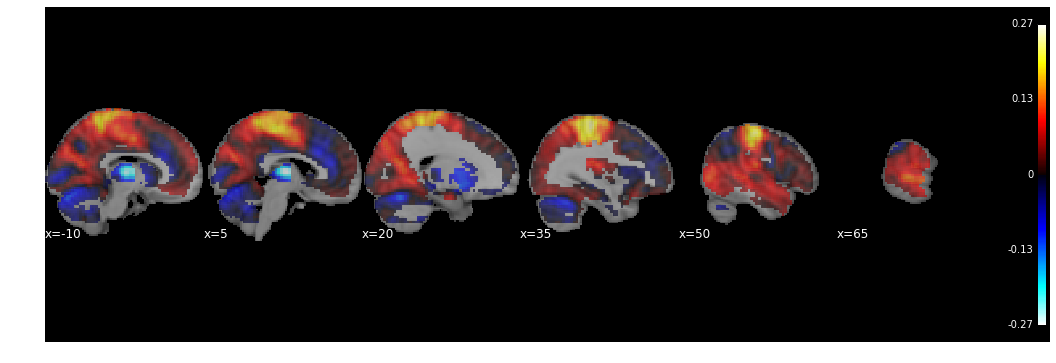

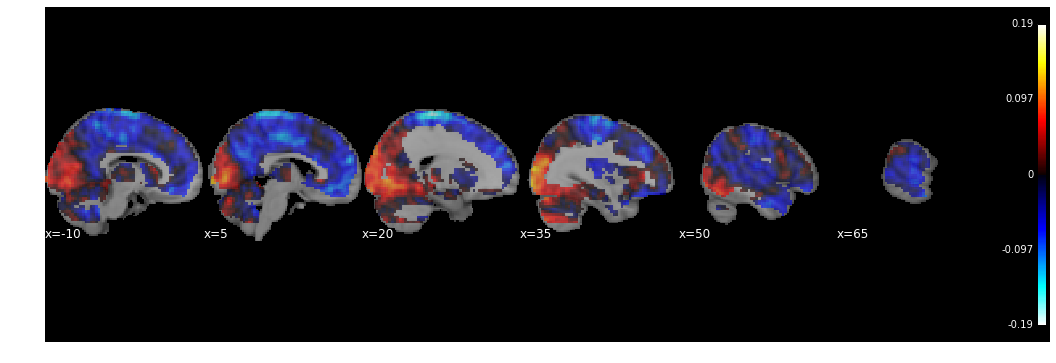

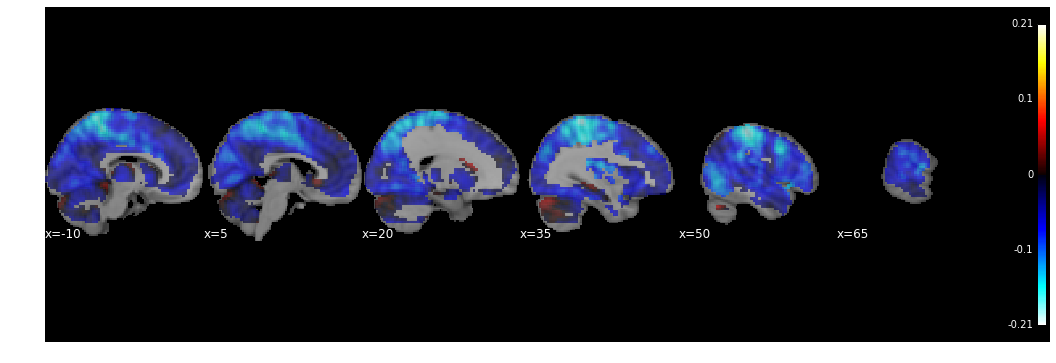

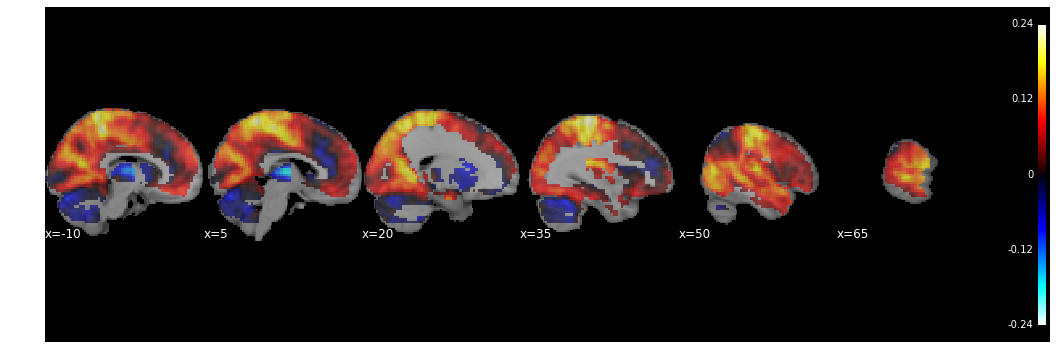

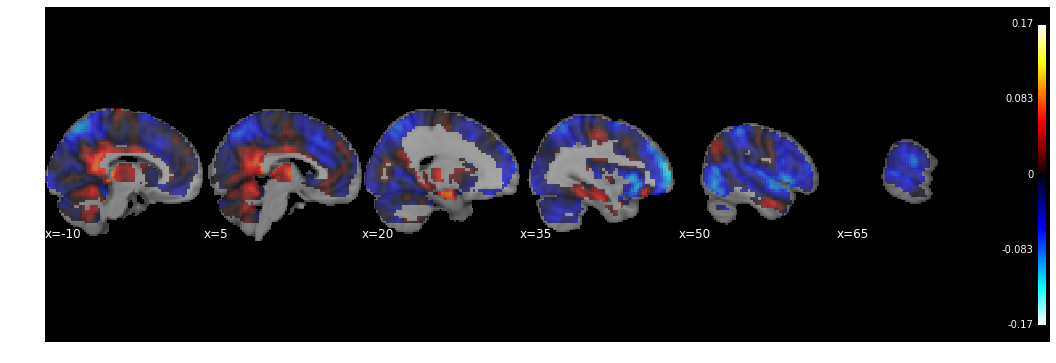

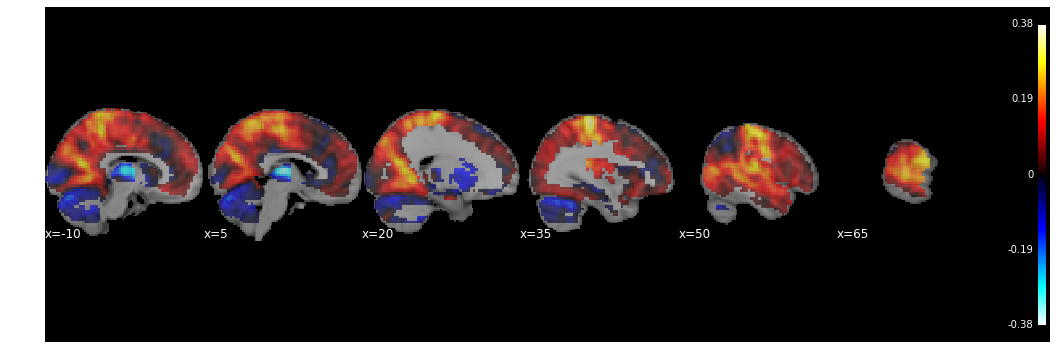

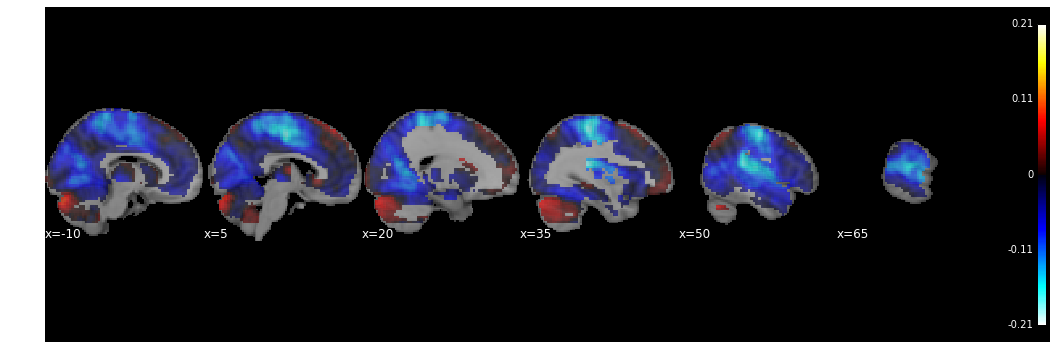

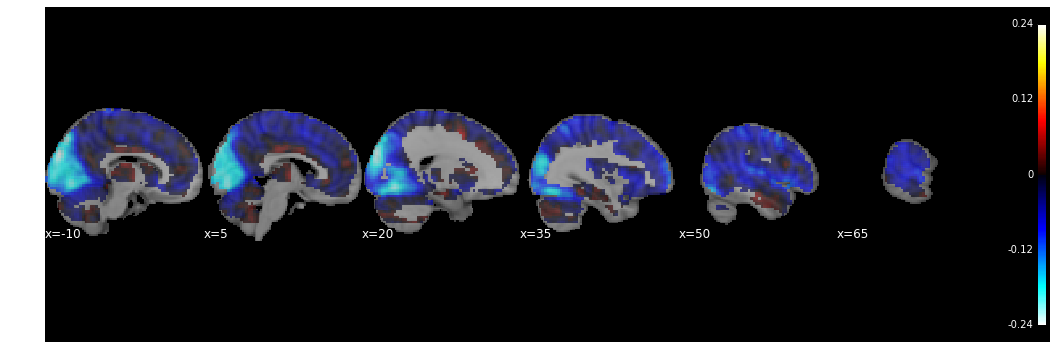

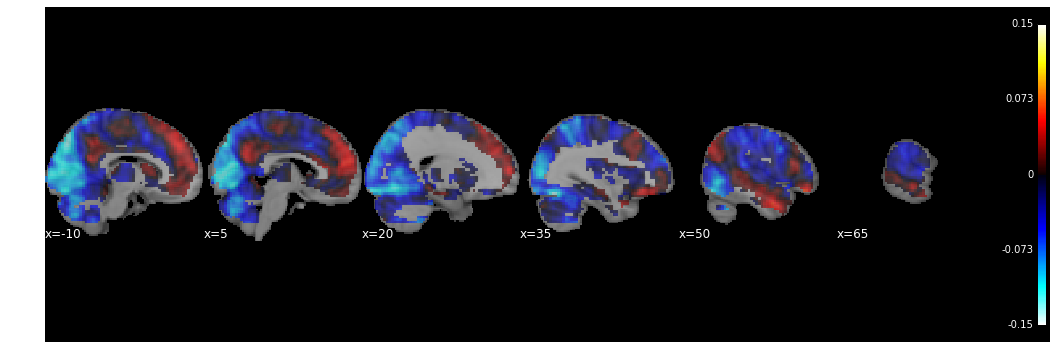

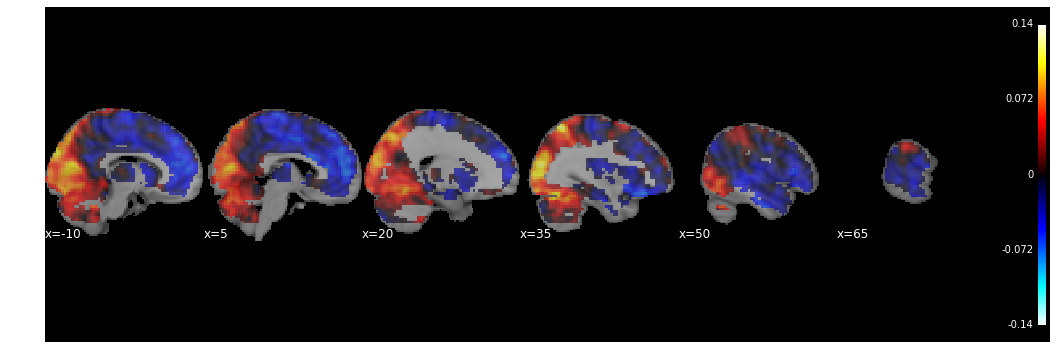

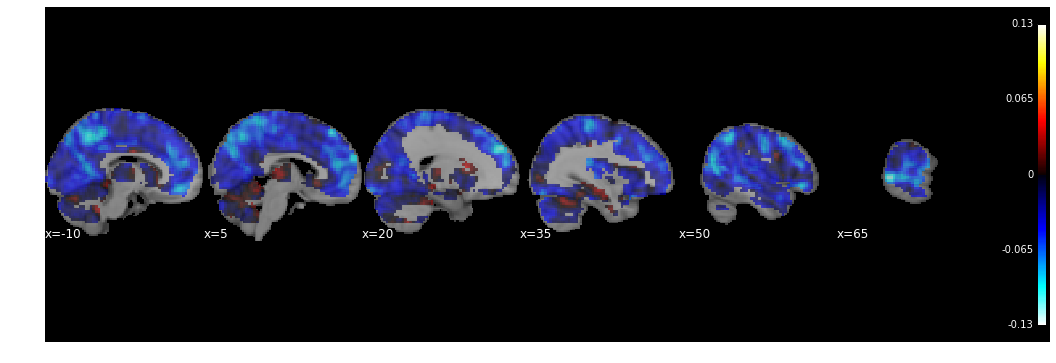

In [98]:
# Get the raw maps
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netstack_raw = np.load(netraw_path)

# Iterate through all above threshold findings
net_hits, sbt_hits = np.where(pthresh)
# Find the unique networks that have hit
nets = np.unique(net_hits)
# Get the pheno stuff
cov_index = pd.notnull(pheno[cov])
cov_val = pheno[cov_index][cov].values
# Setup the text overlay
font = {'family': 'serif',
    'color':  'lime',
    'weight': 'heavy',
    'size': 18,
    }
txt_offset=8

# Loop through the networks
for network in nets:    
    net_match = match_file['ind_ovlp'][network][0]
    # Turn that into the python 0-based net id
    net_match_id = net_match - 1
    # Find the overlap with this network
    net_overlap = match_file['score_ovlp'][network]
    
    # Get the subtypes with significant results for 
    # the current network
    sbts = sbt_hits[net_hits==network]
    
    # Now start plotting the subtypes
    for pid, sbt in enumerate(sbts):
        # subtype figure
        fig_c = plt.figure(figsize=(18,6))
        ax_3a = fig_c.add_subplot(111)
        
        res = res_store[network][sbt]
        # Get sbt t-value
        sbt_t = res.tvalues[cov]
        # code orientation
        if sbt_t < 0:
            orient = 'negative'
        else: 
            orient = 'positive'
        # Show the subtype
        sbt_map = sbt_store[network, sbt,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt_map
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', alpha=0.6,
                          cut_coords=np.arange(-10,70,15), black_bg=True,axes=ax_3a)
        #fig_name = 'net_{}_sbt_{}_{}_montage.png'.format(network, sbt, orient)
        #fig_c.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
        #                pad_inches=0)

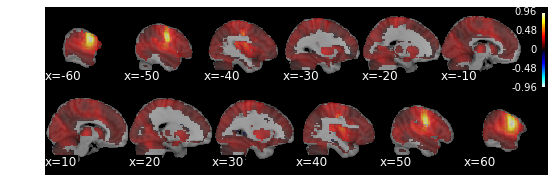

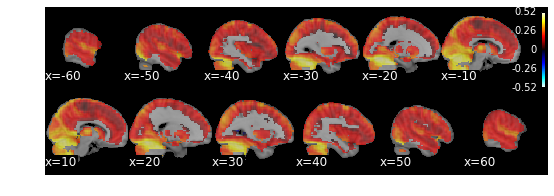

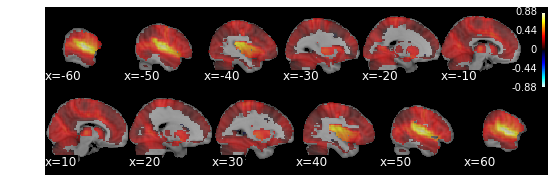

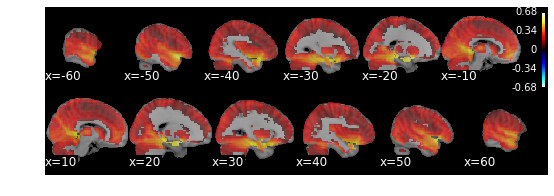

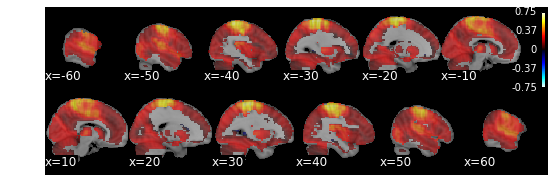

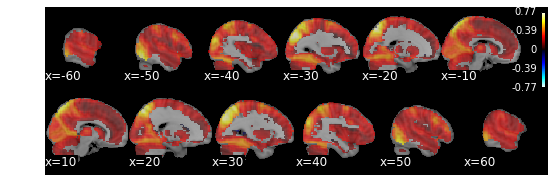

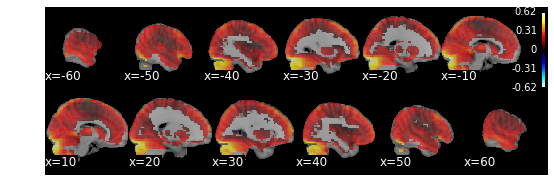

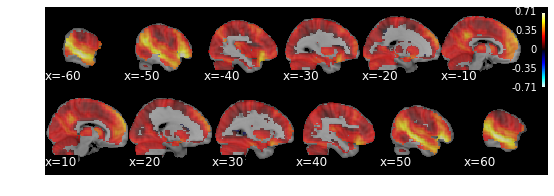

In [317]:
for network in nets:
    # Get the seed map
    netmaps = netstack_raw[network,...]
    netavg = np.mean(netmaps, axis=1)
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = netavg
    avg_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    # Display the seed map
    fig_e = plt.figure(figsize=(9,3))
    gs5 = gridspec.GridSpec(2, 1, hspace=0)
    ax_5a = fig_e.add_subplot(gs5[0,0])
    ax_5b = fig_e.add_subplot(gs5[1,0])
    
    nlp.plot_stat_map(avg_img, display_mode='x', alpha=0.6,
                      cut_coords=np.arange(-60,0,10), black_bg=True, axes=ax_5a)
    nlp.plot_stat_map(avg_img, display_mode='x', colorbar=False, alpha=0.6,
                      cut_coords=np.arange(10,61,10), black_bg=True,axes=ax_5b)
    fig_name = 'net_{}_seed.png'.format(network, sbt, orient)
    fig_e.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

In [93]:
np.arange(-10,50,10)

array([-10,   0,  10,  20,  30,  40])

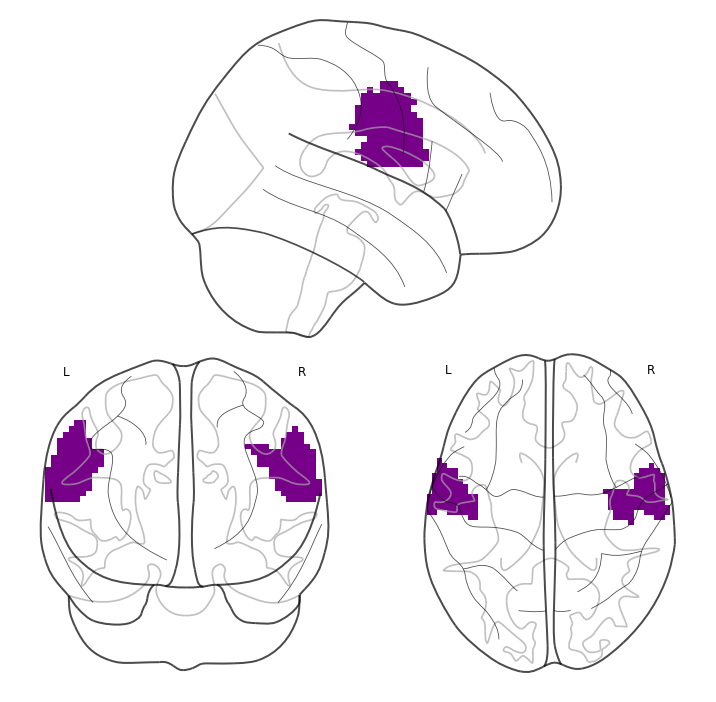

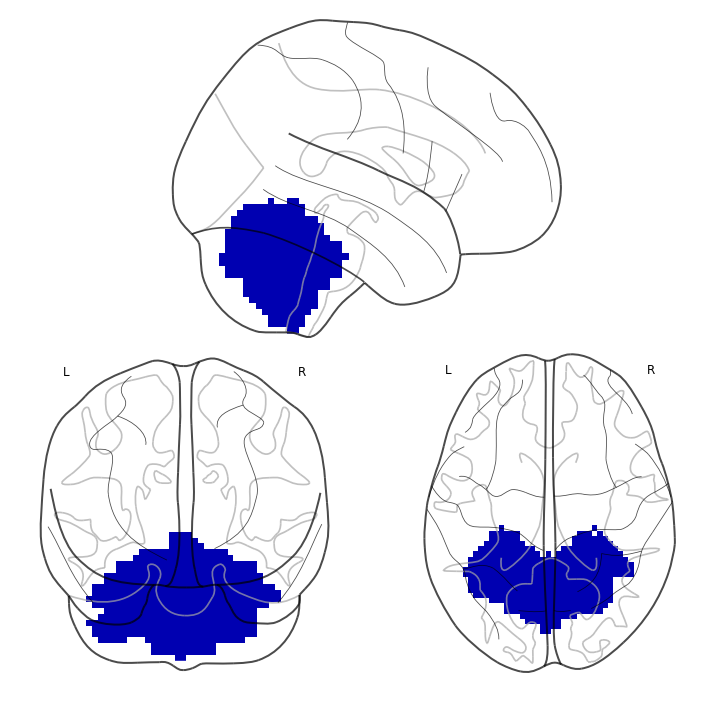

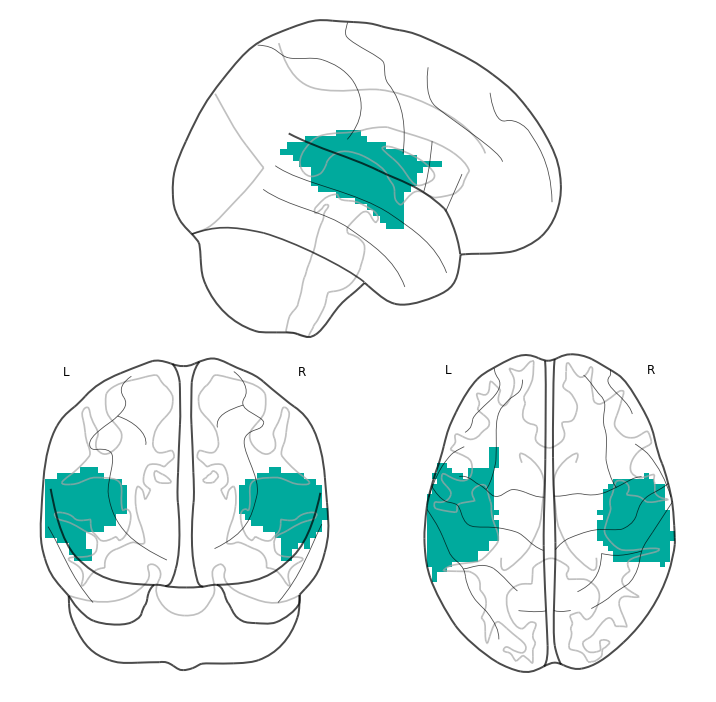

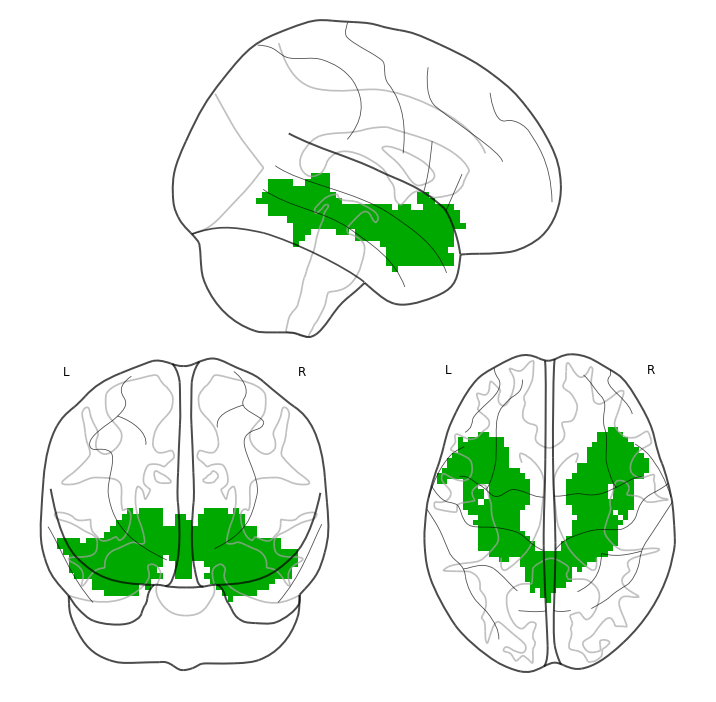

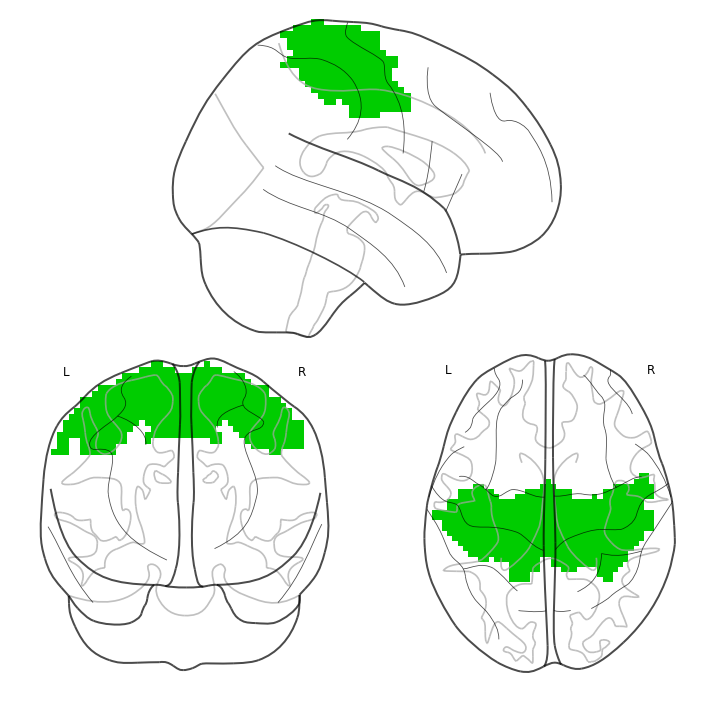

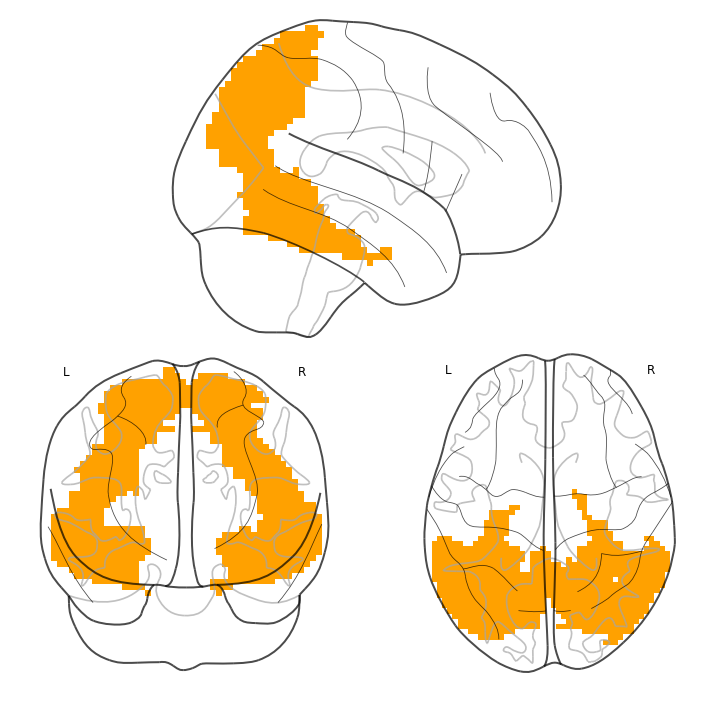

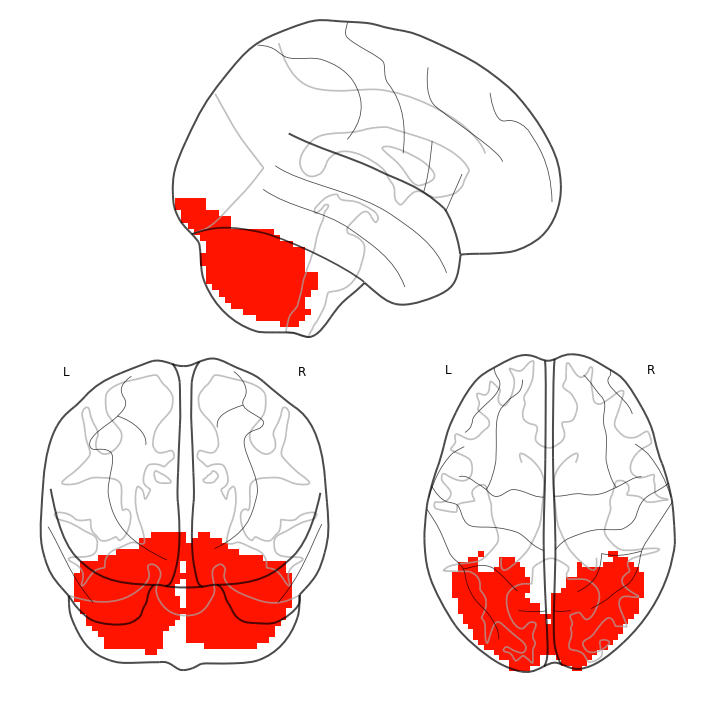

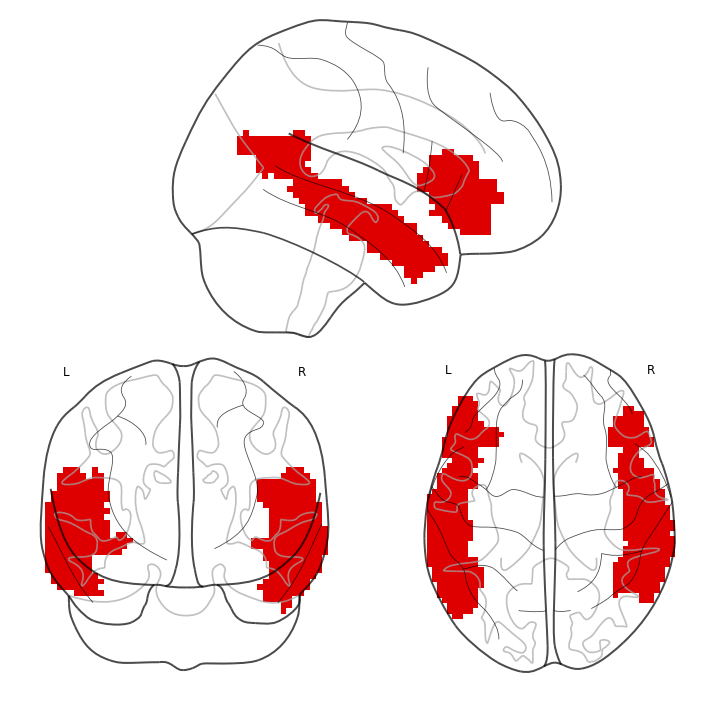

In [204]:
# Make one more kind of montage for the networks
for network in nets:
    # Plot the network
    fig_f = plt.figure(figsize=(12,12))
    gs1 = gridspec.GridSpec(2, 2, hspace=0)
    ax_6a = fig_f.add_subplot(gs1[0,:])
    ax_6b = fig_f.add_subplot(gs1[1,0])
    ax_6c = fig_f.add_subplot(gs1[1,1])
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_6a, display_mode='x')
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_6b, display_mode='y')
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale,axes=ax_6c, display_mode='z')
    
    fig_name = 'net_{}_triple.png'.format(network, sbt, orient)
    fig_f.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)
    plt.close()

In [306]:
np.where(part_test==sbt_use)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

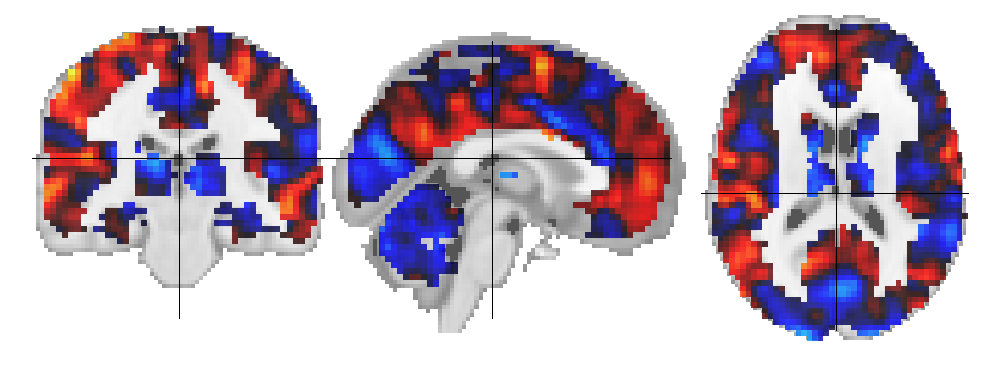

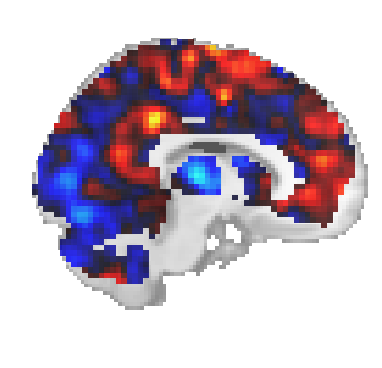

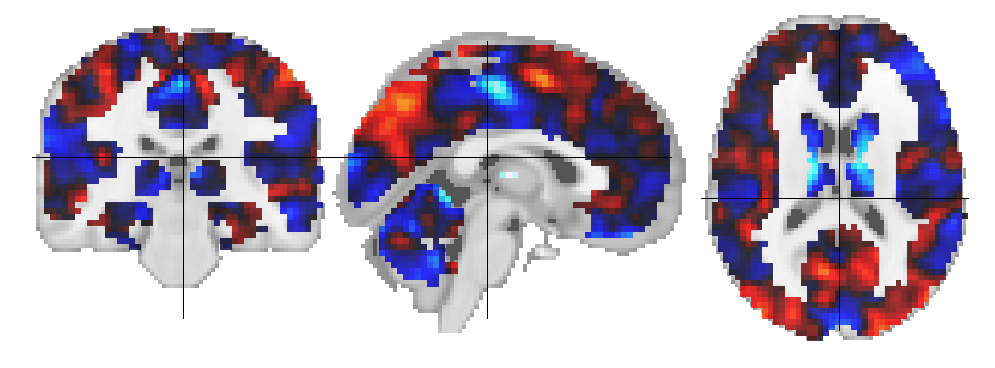

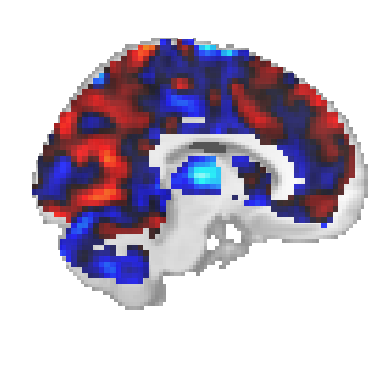

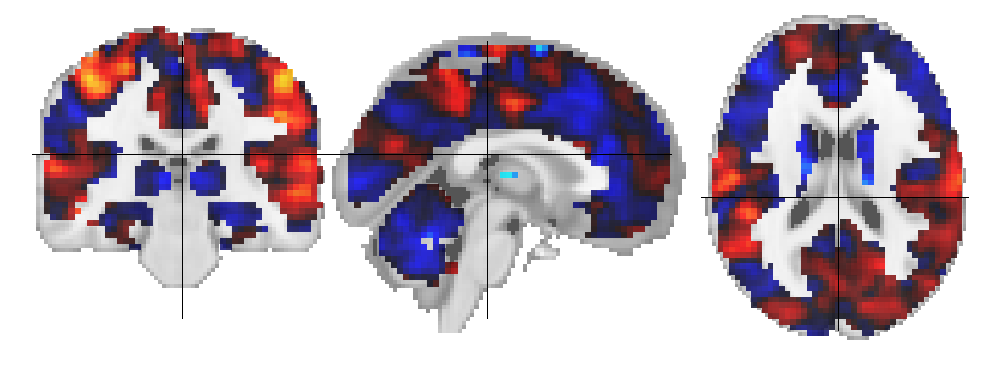

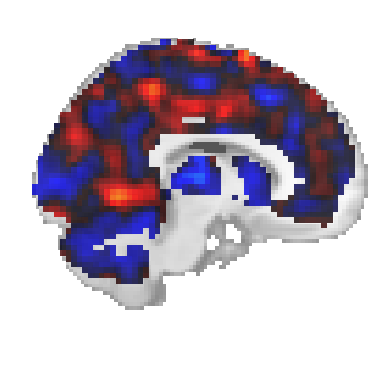

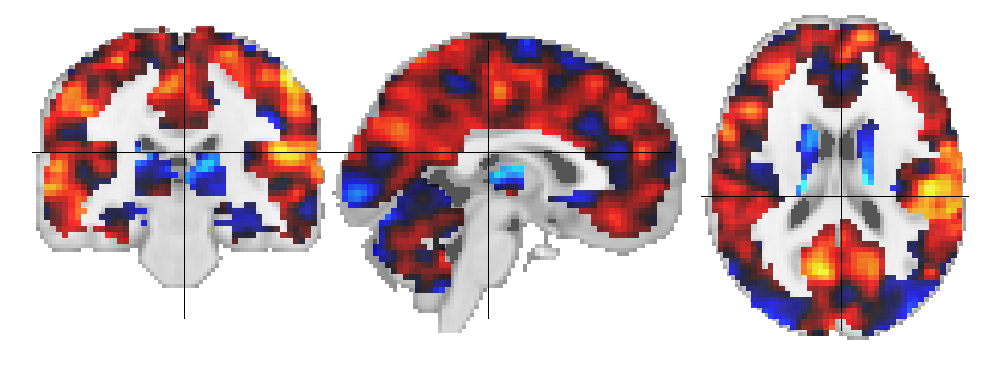

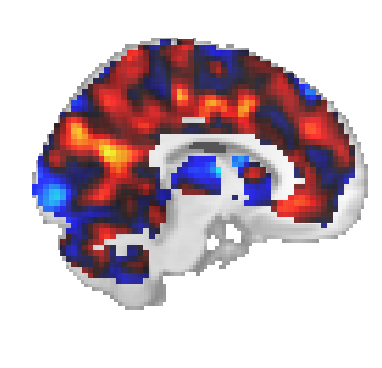

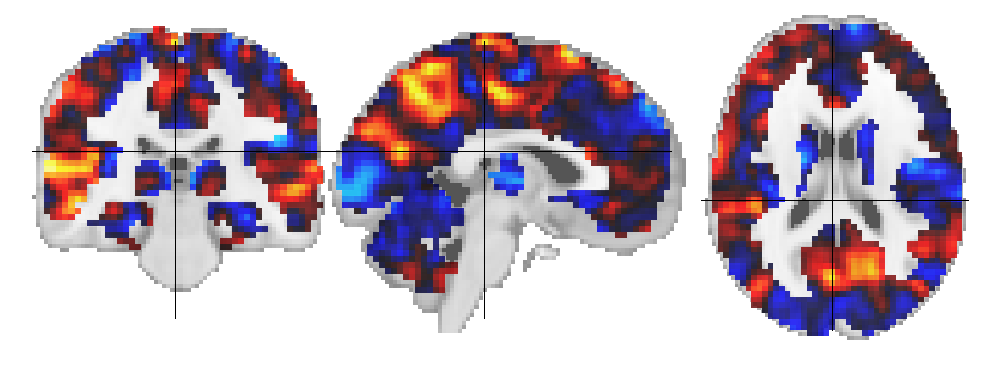

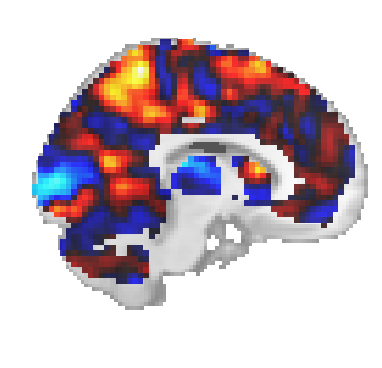

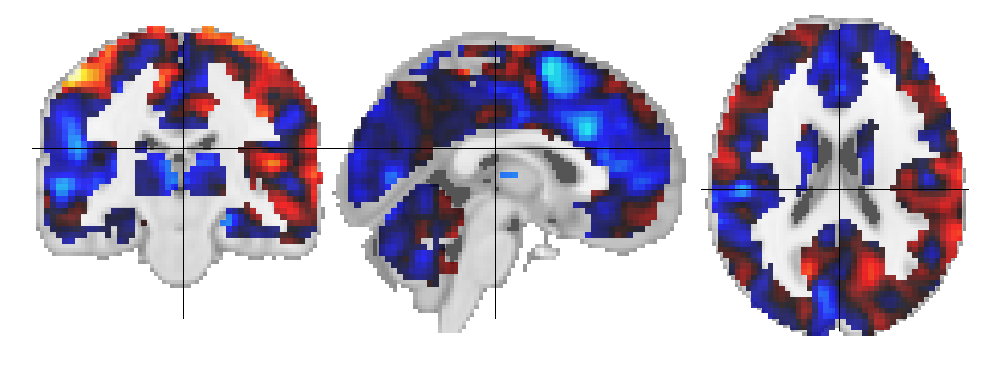

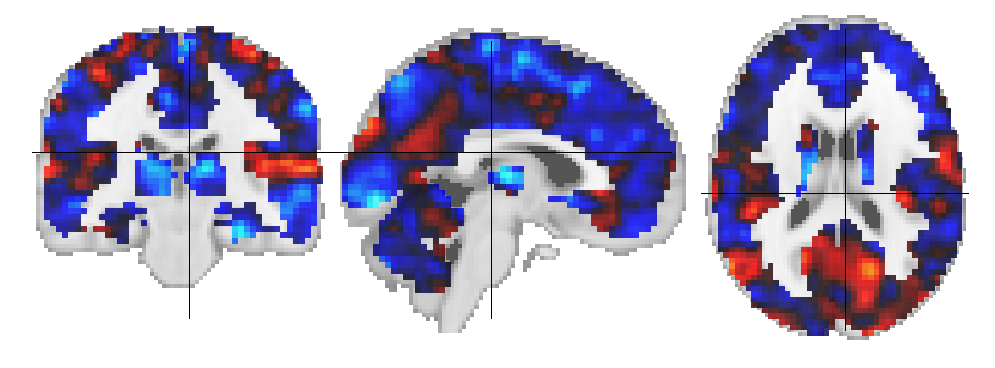

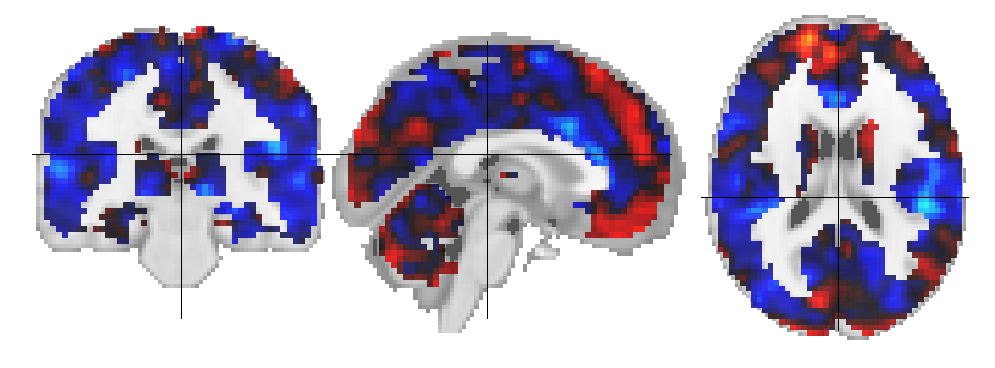

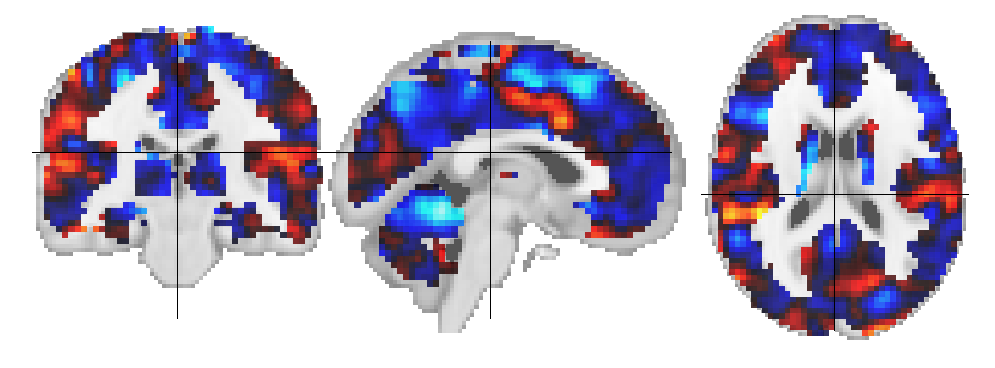

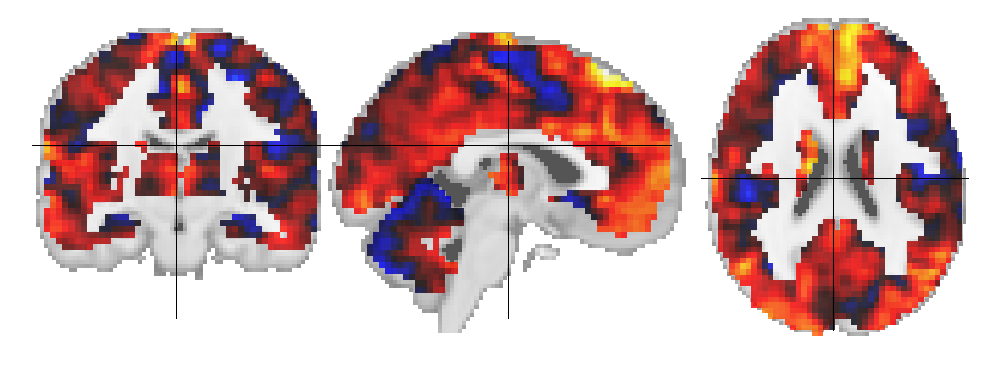

In [321]:
# Individual seed maps
netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netstack = np.load(netstack_path)
network = 10 # for somatomotor
somstack = netstack[network, ...]

# Get the partition
link_mat = scl.hierarchy.linkage(corr_mat[network, ...] , method='ward')
ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
# Prepare the partition overlay
part_test = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')

# We use subtype 0
sbt_use = 1
sbt_notuse = [5,3]

sublist = np.where(part_test==sbt_use)[0]
notlist = np.where(part_test!=sbt_use)[0]

for sub in sublist[:5]:
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = somstack[:, sub]
    sub_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig_i = plt.figure(figsize=(17,6))
    ax_7 = fig_i.add_subplot(111)
    nlp.plot_stat_map(sub_img, display_mode='ortho', alpha=0.8,
                      black_bg=False,axes=ax_7, colorbar=False, annotate=False)
    fig_name = 'individual_somato_sbt_0_map_{}.png'.format(sub)
    fig_i.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)
    
    fig_i = plt.figure(figsize=(6,6))
    ax_7 = fig_i.add_subplot(111)
    nlp.plot_stat_map(sub_img, display_mode='x', alpha=0.8, cut_coords=[-10],
                      black_bg=False,axes=ax_7, colorbar=False, annotate=False)
    fig_name = 'individual_somato_sbt_0_single_{}.png'.format(sub)
    fig_i.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)
    
    
for sub in notlist[:5]:
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = somstack[:, sub]
    sub_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig_i = plt.figure(figsize=(17,6))
    ax_7 = fig_i.add_subplot(111)
    clb = nlp.plot_stat_map(sub_img, display_mode='ortho', alpha=0.8,
                      black_bg=False,axes=ax_7, colorbar=False, annotate=False)
    fig_name = 'individual_somato_other_subtype_{}.png'.format(sub)
    fig_i.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

AttributeError: 'OrthoSlicer' object has no attribute 'autoscale_None'

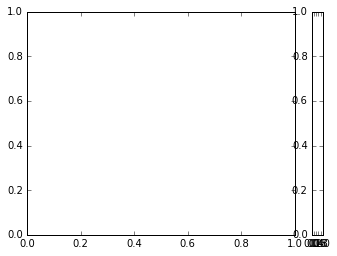

In [323]:
plt.colorbar(clb)

In [285]:
# Get better similarity matrices (bigger lines)
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netstack_raw = np.load(netraw_path)

# Iterate through all above threshold findings
net_hits, sbt_hits = np.where(pthresh)
# Find the unique networks that have hit
nets = np.unique(net_hits)
# Get the pheno stuff
cov_index = pd.notnull(pheno[cov])
cov_val = pheno[cov_index][cov].values
# Setup the text overlay
font = {'family': 'serif',
    'color':  'lime',
    'weight': 'heavy',
    'size': 18,
    }
txt_offset=8

# Loop through the networks
for network in nets:    
    net_match = match_file['ind_ovlp'][network][0]
    # Turn that into the python 0-based net id
    net_match_id = net_match - 1
    # Find the overlap with this network
    net_overlap = match_file['score_ovlp'][network]
    
    # Plot the correlation matrix
    link_mat = scl.hierarchy.linkage(corr_mat[network, ...] , method='ward')
    ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
    tmp = corr_mat[network, ...]
    show_mat = tmp[ind, :][:, ind]
    # Prepare the partition overlay
    part_test = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')[ind]
    part_frame = np.zeros(show_mat.shape)
    for sbt_id in np.arange(subtypes):
        # Get first and last element
        hits = np.where(part_test==sbt_id+1)[0]
        first = hits[0]
        last = hits[-1]
        if first > 1:
            # We can probably go back 4
            frontup = (first-3, first-2, first-1, first)
            selstart = first-3
        else:
            frontup = (first,)
            selstart = first
        if last < part_frame.shape[0] - 3:
            # we can probably extend 4
            backtup = (last, last+1, last+2, last+3)
            selstop = last+3
        else:
            backtup = (last,)
            selstop = last
        # Draw column
        devtuple = frontup + backtup
        part_frame[selstart:selstop, devtuple] = 1
        # Draw rows 
        part_frame[devtuple, selstart:selstop] = 1
    part_frame = np.ma.masked_where(part_frame == 0, part_frame)
    
    fig_b = plt.figure(figsize=(6,6))
    ax_2a = fig_b.add_subplot(111)
    ax_2a.matshow(show_mat, vmin=-0.2, vmax=0.2, cmap=bb.visu.hot_cold())
    ax_2a.matshow(part_frame, cmap=plt.cm.Greys, alpha=1)
    ax_2a.set_xticklabels([])
    ax_2a.set_yticklabels([])
    
    fig_name = 'net_{}_corrmat_improved.png'.format(network)
    fig_b.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)
    
    plt.close()

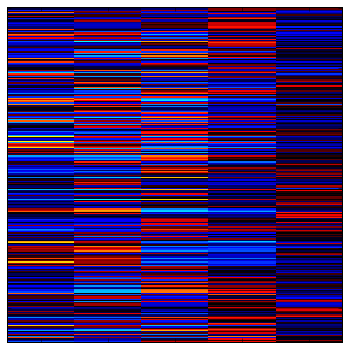

In [197]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)* 
ax.matshow(weight_store[network,...].T, aspect='auto', cmap=bb.visu.hot_cold())
ax.set_xticklabels([])
ax.set_yticklabels([])
fig_name = 'net_{}_weightmat.png'.format(network)
fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)

In [203]:
# Single frame subtype maps
network = 10 # for somatomotor

for sbt in np.arange(subtypes):
    # subtype figure
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    sbt_map = sbt_store[network, sbt,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_map
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, annotate=False,
                      cut_coords=[-10], black_bg=False,axes=ax, colorbar=False)
    fig_name = 'net_{}_sbt_{}_single.png'.format(network, sbt)
    fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

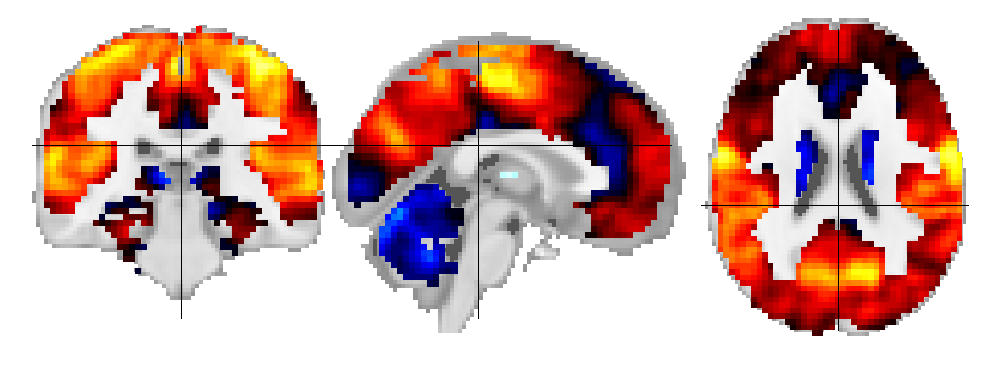

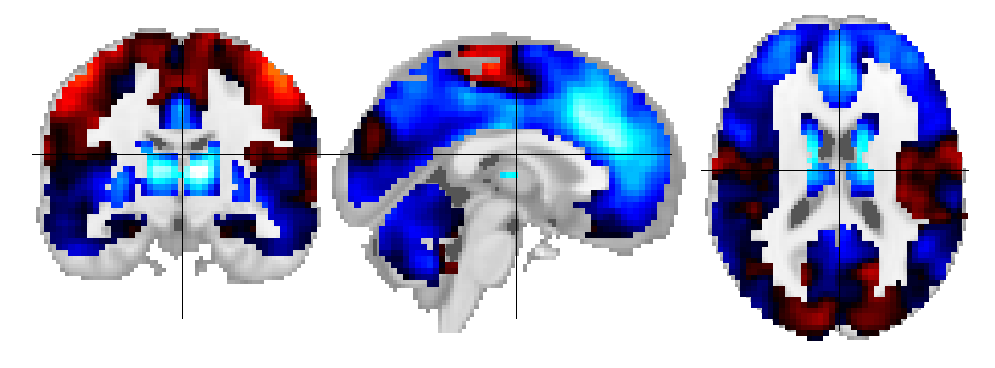

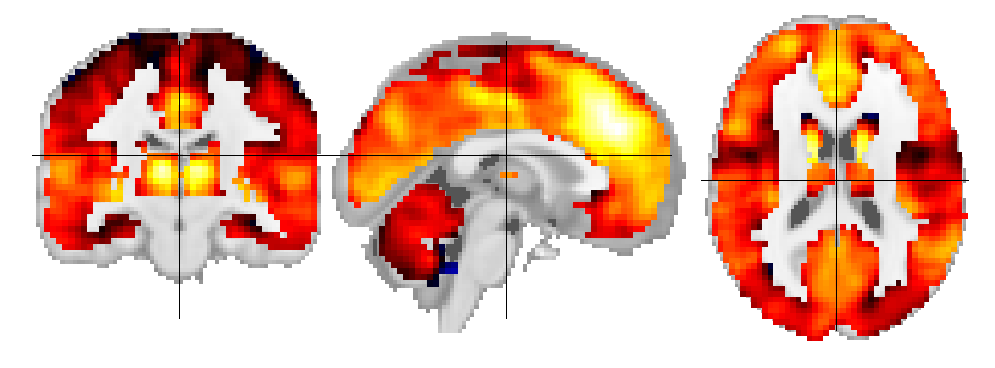

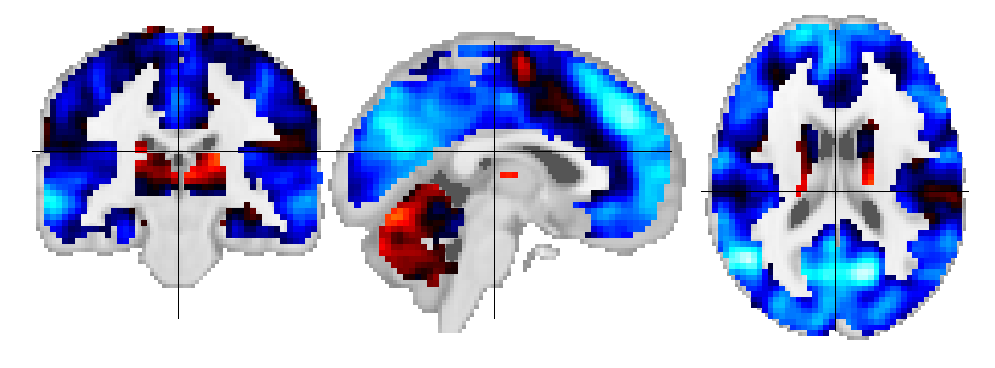

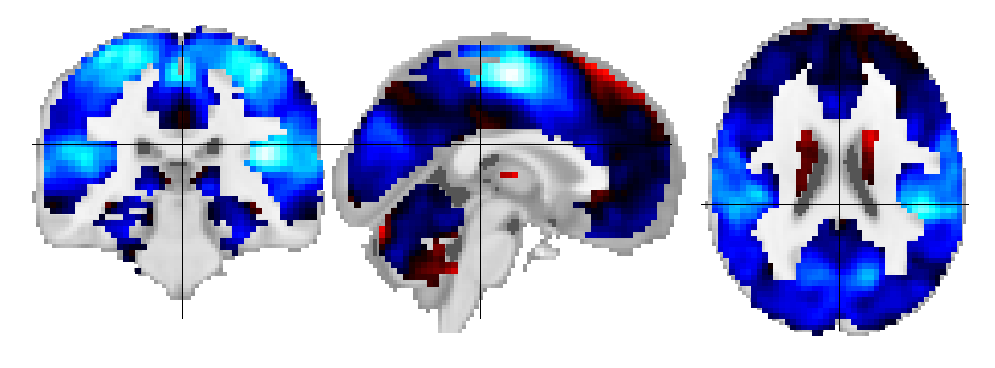

In [316]:
# Single frame subtype maps
network = 10 # for somatomotor

for sbt in np.arange(subtypes):
    # subtype figure
    fig = plt.figure(figsize=(17,6))
    ax = fig.add_subplot(111)
    sbt_map = sbt_store[network, sbt,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_map
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_img, display_mode='ortho', threshold=0, annotate=False,
                      black_bg=False,axes=ax, colorbar=False)
    fig_name = 'net_{}_sbt_{}_straight.png'.format(network, sbt)
    fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

In [236]:
# Make new image in one with same numbers
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp_one = np.zeros(prior_data.shape)
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp_one += tmp
prior_temp_one = prior_temp_one * 2 - 20
one_prior_img = nib.Nifti1Image(prior_temp_one, affine=m_img.get_affine(), header=m_img.get_header())

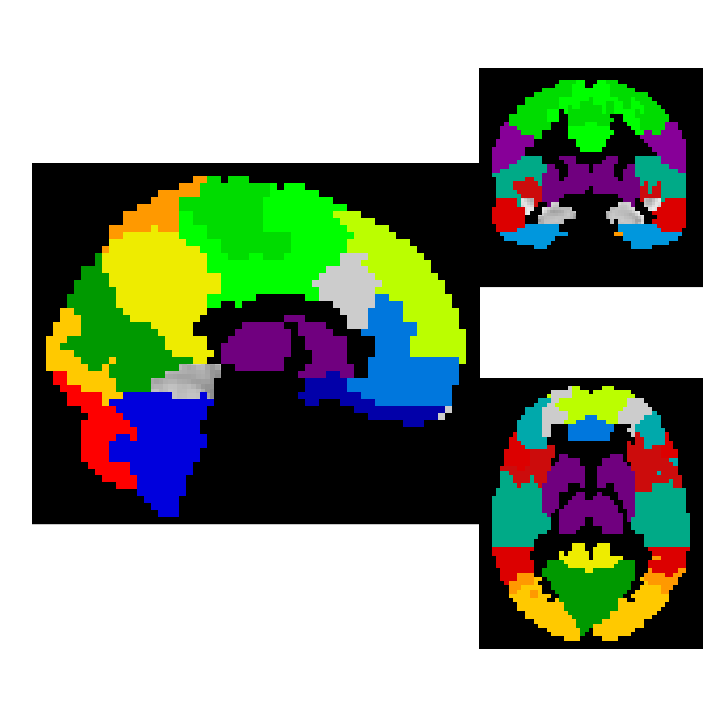

In [253]:
fig = plt.figure(figsize=(12,12))
gs1 = gridspec.GridSpec(2, 3, hspace=0, wspace=0)
ax_6a = fig.add_subplot(gs1[:,:2])
ax_6b = fig.add_subplot(gs1[0, 2])
ax_6c = fig.add_subplot(gs1[1, 2])
nlp.plot_stat_map(one_prior_img, cmap=plt.cm.spectral, symmetric_cbar=True,
                     colorbar=False, vmax=scale, display_mode='x', axes=ax_6a,
                 cut_coords=[-10], annotate=False)
nlp.plot_stat_map(one_prior_img, cmap=plt.cm.spectral, symmetric_cbar=True,
                     colorbar=False, vmax=scale, display_mode='y', axes=ax_6b,
                 cut_coords=[-10], annotate=False)
nlp.plot_stat_map(one_prior_img, cmap=plt.cm.spectral, symmetric_cbar=True,
                     colorbar=False, vmax=scale, display_mode='z', axes=ax_6c,
                 cut_coords=[10], annotate=False)

fig_name = 'full_parcellation.png'.format(network, sbt)
fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

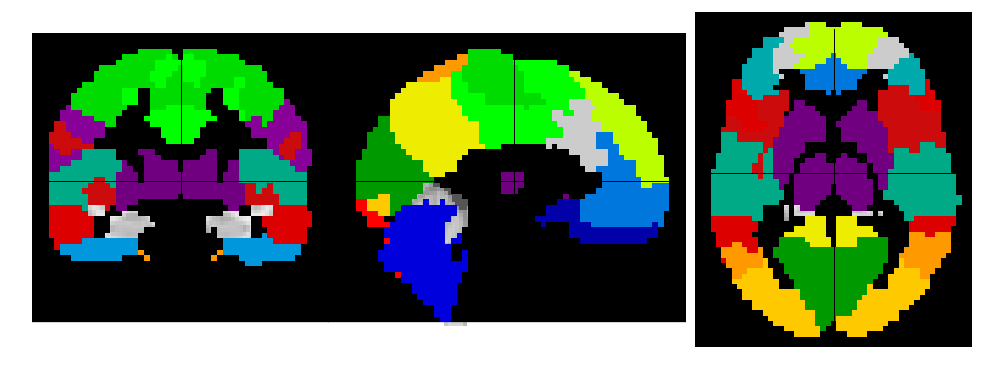

In [293]:
fig = plt.figure(figsize=(17,6))
ax_6a = fig.add_subplot(111)
nlp.plot_stat_map(one_prior_img, cmap=plt.cm.spectral, symmetric_cbar=True,
                     colorbar=False, vmax=scale, display_mode='ortho', axes=ax_6a, annotate=False)

fig_name = 'full_parcellation_straight.png'.format(network, sbt)
fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

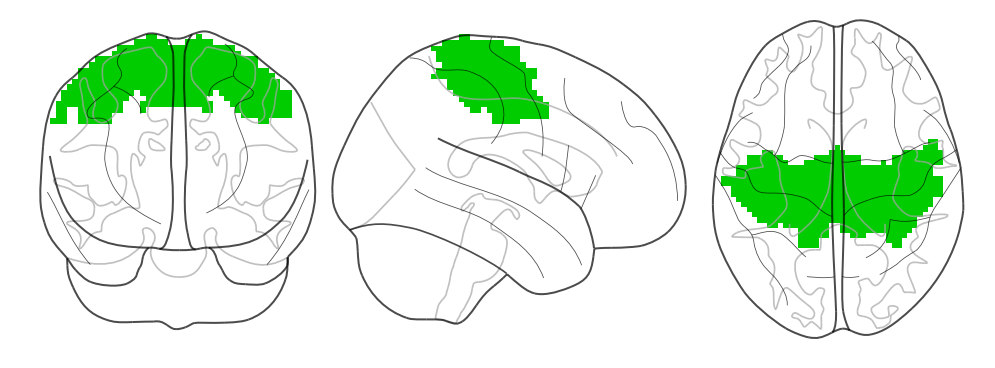

In [301]:
fig = plt.figure(figsize=(17,6))
ax_6a = fig.add_subplot(111)
nlp.plot_glass_brain(nil.image.index_img(prior_img, 10), cmap=plt.cm.spectral, annotate=False,
                         colorbar=False, vmin=1, vmax=scale,axes=ax_6a, display_mode='ortho')

fig_name = 'net_10_parcellation_straight.png'.format(network, sbt)
fig.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                    pad_inches=0)

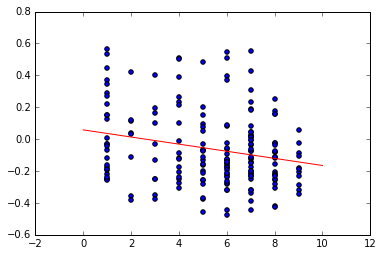

In [267]:
# Fit GLM to pointcloud
cov_index = pd.notnull(pheno[cov])
cov_val = pheno[cov_index][cov].values
sbt_w = weight_store[10, 0, cov_index.values]
plt.scatter(cov_val, sbt_w)
plt.plot(x_reg, y_reg, 'r')

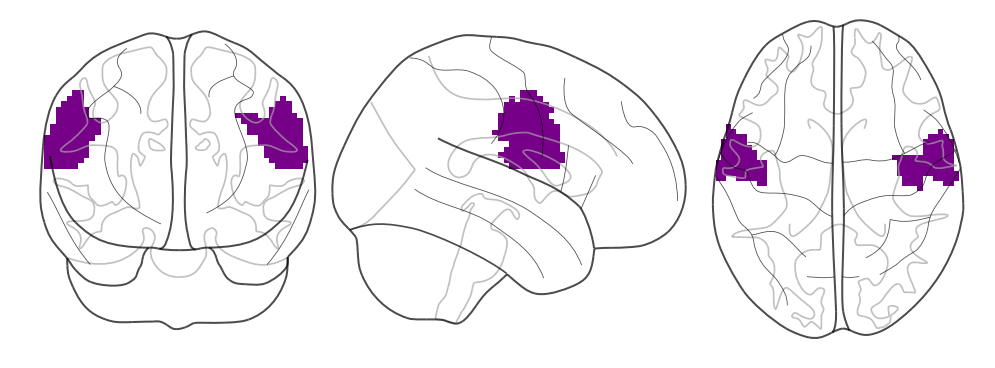

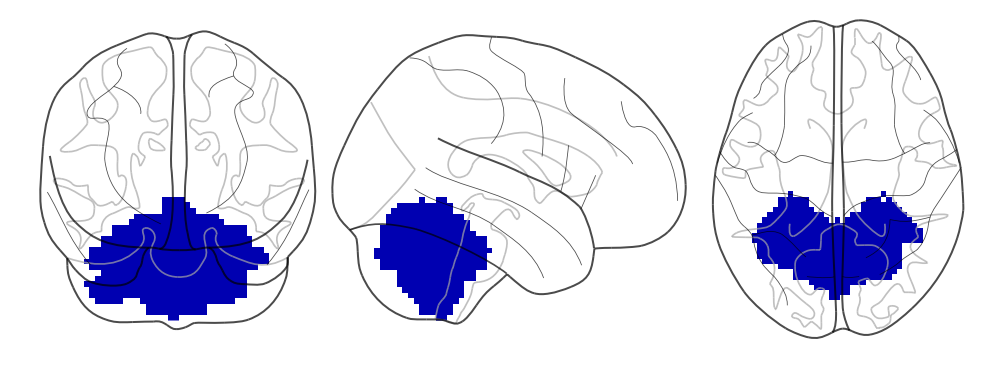

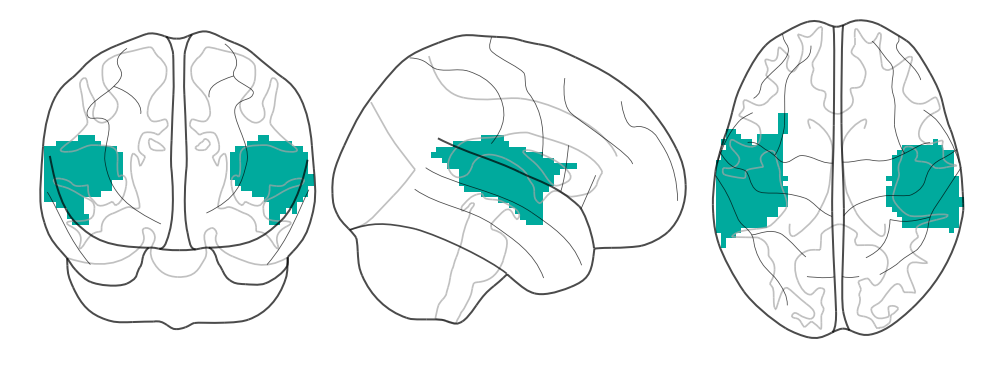

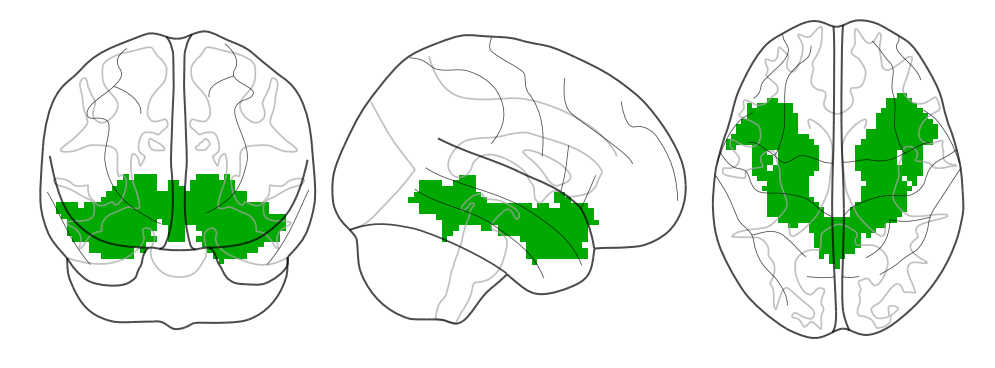

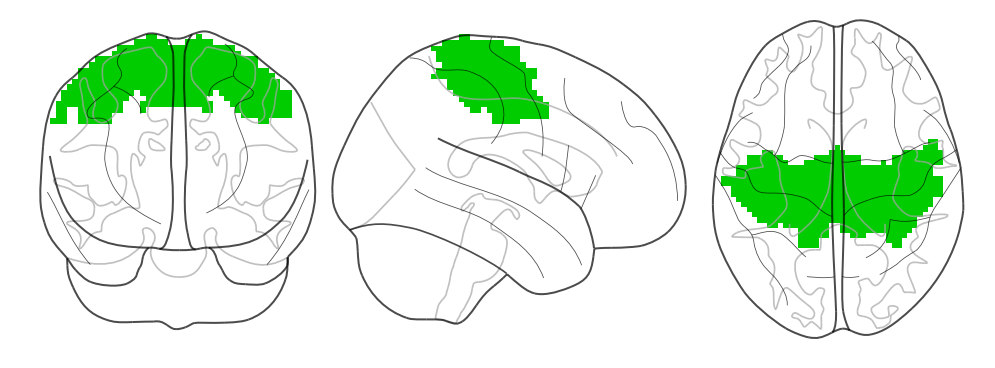

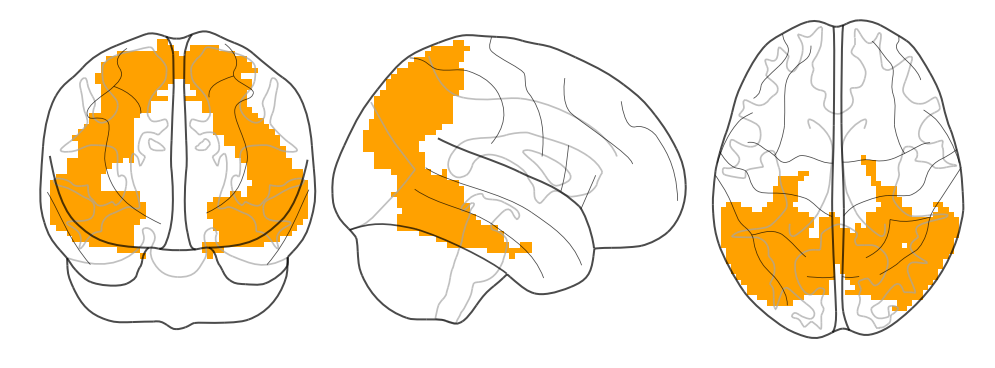

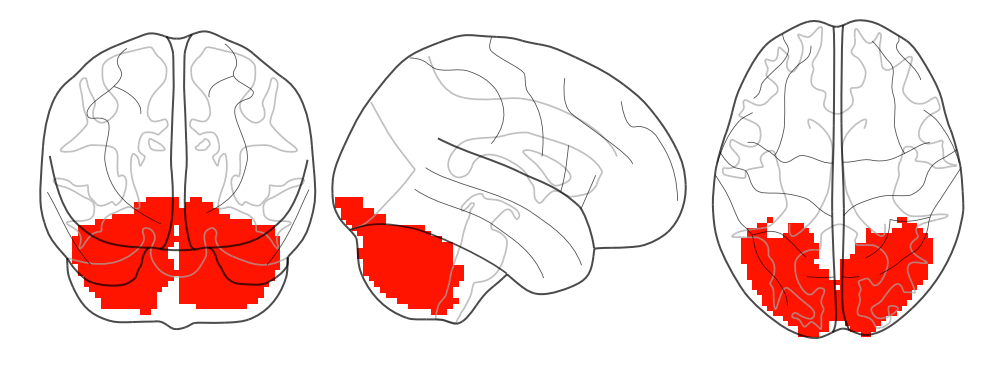

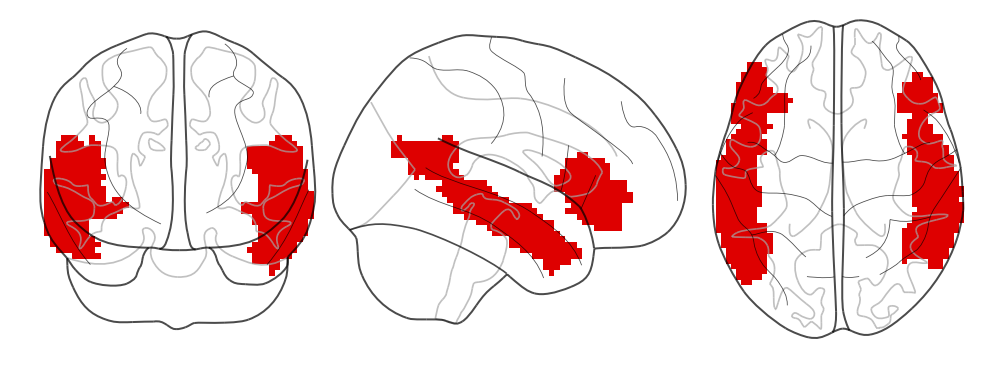

In [303]:
# Make straight network maps
# Iterate through all above threshold findings
net_hits, sbt_hits = np.where(pthresh)
# Find the unique networks that have hit
nets = np.unique(net_hits)

# Loop through the networks
for network in nets:    
        
    # Plot the network
    fig_a = plt.figure(figsize=(17,6))
    ax_1a = fig_a.add_subplot(111)
    
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, annotate=False,
                         colorbar=False, vmin=1, vmax=scale,axes=ax_1a, display_mode='ortho')
        
    # Save the figure
    fig_name = 'net_{}_straight.png'.format(network)
    fig_a.savefig(os.path.join(out_path, fig_name), transparent=False, bbox_inches='tight',
                        pad_inches=0)